# Environmental footprint of digital content consumption - LCA results analysis

In [1]:
import brightway2 as bw
import presamples as ps
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Basic set-up

In [2]:
PROJECT_NAME = 'iri' # <- insert your project name here
bw.projects.set_current(PROJECT_NAME)

In [3]:
# Databases used:
DBS = {
       'Ecoinvent':            'ecoinvent 3.8 cutoff',
       'Ecoinvent 2050':       'ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 (premise v1.3.9)',
       'Digital content':      'Digital Content Consumption',
       'Digital content 2030': 'Digital Content Consumption, IMAGE SSP2-RCP19, 2030 (premise v1.3.9)',
       'Digital content 2040': 'Digital Content Consumption, IMAGE SSP2-RCP19, 2040 (premise v1.3.9)',
       'Digital content 2050': 'Digital Content Consumption, IMAGE SSP2-RCP19, 2050 (premise v1.3.9)'
      }

# LCIA methods:
LCIA_METHODS = {
                'Carbon footprint':                 ('IPCC 2021', 'climate change: including SLCFs', 'GWP 100a, incl. H and bio CO2'),
                'Climate change':                   ('IPCC 2021', 'climate change: CO2 emissions'),
                'Acidification':                    ('EF v3.0', 'acidification', 'accumulated exceedance (ae)'),
                'Eutrophication, freshwater':       ('EF v3.0', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)'),
                'Eutrophication, marine':           ('EF v3.0', 'eutrophication: marine', 'fraction of nutrients reaching marine end compartment (N)'),
                'Eutrophication, terrestrial':      ('EF v3.0', 'eutrophication: terrestrial', 'accumulated exceedance (AE) '),
                'Photochemical ozone formation':    ('EF v3.0', 'photochemical ozone formation: human health', 'tropospheric ozone concentration increase'),
                'Particulate matter formation':     ('EF v3.0', 'particulate matter formation', 'impact on human health'),
                'Ozone depletion':                  ('EF v3.0', 'ozone depletion', 'ozone depletion potential (ODP) '),
                'Ecotoxicity, freshwater':          ('EF v3.1 adapted to biosphere ei38', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)'),
                'Human toxicity, carcinogenic':     ('EF v3.1 adapted to biosphere ei38', 'human toxicity: carcinogenic', 'comparative toxic unit for human (CTUh)'),
                'Human toxicity, non-carcinogenic': ('EF v3.1 adapted to biosphere ei38', 'human toxicity: non-carcinogenic', 'comparative toxic unit for human (CTUh)'),
                'Ionising radiation':               ('EF v3.0', 'ionising radiation: human health', 'human exposure efficiency relative to u235'), 
                'Resource use, fossils':            ('EF v3.0', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels'),
                'Resource use, mineral and metals': ('EF v3.0', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)'),
                'Land use, soil erosion':           ('LANCA v2.5 - land use', 'erosion potential'),
                'Freshwater use':                   ('selected LCI results, additional', 'resource', 'water')
               }

# Assessed locations
LOCATIONS = {
             'GLO': 'World', 
             'BR': 'Brazil', 
             'CA': 'Canada',
             'CN': 'China',
             'IN': 'India',
             'US': 'United States',
             'NO': 'Norway',
             'CH': 'Switzerland',
             'FR': 'France',
             'DK': 'Denmark',
             'ES': 'Spain',
             'IT': 'Italy',
             'DE': 'Germany',
             'PL': 'Poland',
             'GB': 'United Kingdom',
             'ZA': 'South Africa',
             'AU': 'Australia',
             'RU': 'Russia'
             }

In [4]:
# Import per capita carrying capacities for EF indicators
carrying_capacity_per_capita = pd.read_excel(Path(r"..\data\LCIA_Carrying-Capacities.xlsx"), index_col=0)
carrying_capacity_per_capita

,Unit,carrying_capacity_2020,carrying_capacity_2030,carrying_capacity_2040,carrying_capacity_2050
Impact category,,,,,
Climate change,kg CO2/person/year,500.563828,500.563828,500.563828,500.563828
Acidification,mol H+-eq/person/year,128.290676,116.979760,108.709272,102.721779
"Eutrophication, freshwater",kg P-eq/person/year,0.745317,0.679605,0.631557,0.596772
"Eutrophication, marine",kg N-eq/person/year,2.989173,2.725628,2.532926,2.393417
"Eutrophication, terrestrial",mol N-eq/person/year,786.421845,717.085928,666.387836,629.684505
Photochemical ozone formation,kg NMVOC-eq/person/year,52.170789,47.571083,44.207799,41.772921
Particulate matter formation,disease incidence/person/year,0.000075,0.000075,0.000075,0.000075
Ozone depletion,kg CFC-11-eq/person/year,0.046185,0.042113,0.039135,0.036980
"Ecotoxicity, freshwater",CTUe/person/year,16630.272844,15164.042947,14091.942637,13315.786156


In [5]:
# IDs used:
USERS = ['Low technology user','Medium technology user', 'High technology user']
DIGITAL_CONTENT = ['Web surfing', 'Social media', 'Video streaming', 'Music streaming', 'Video conferencing']
INTERNET_COMPONENTS = ['End-user devices | operation', 'End-user devices | embodied', 
                       'CPE | operation', 'CPE | embodied', 
                       'Access network', 'Core network', 
                       'Data centres | operation', 'Data centres | embodied']
END_USER_DEVICES = ['Smartphone', 'Tablet', 'Laptop', 'Desktop computer', 'TV']

# Standards for figures format:

# - length single column figure: 89 mm
# - length 1.5 column figure: 120-136 mm
# - length 2 columns figure: 183 mm
# - max. height figure : 247 mm

fig_length = {1:   3.50394,    # 1 column
              1.5: 5.35433, # 1.5 columns
              2:   7.20472}    # 2 columns
fig_height = 9.72441 # maxium height
fontsize_title = 9
fontsize_label = 8
fontsize_legend = 8
fontsize_axs = 8

spineline_width = 0.6

In [6]:
# Run functions to perform LCIA and contribution analysis
%run _Functions_for_results_analysis.ipynb

## Carbon footprint

In [7]:
LCIA_current = lcia_per_user_and_loc(USERS, LOCATIONS, DBS['Digital content'], LCIA_METHODS)

In [8]:
carbon_footprint_loc = {}
for user in LCIA_current:
    carbon_footprint_loc[user] = {}
    for loc in LCIA_current[user]:
        carbon_footprint_loc[user].update({loc: LCIA_current[user][loc]['Carbon footprint']})

carbon_footprint_loc_df = pd.DataFrame(carbon_footprint_loc)
carbon_footprint_loc_df.sort_values('Medium technology user')

,Low technology user,Medium technology user,High technology user
Norway,67.786907,146.306067,205.843974
Switzerland,69.836421,150.470332,210.918467
France,71.395098,153.637302,214.777674
Canada,78.416243,167.903079,232.161672
Denmark,83.601728,178.439107,245.000671
Brazil,84.214266,179.683680,246.517284
United Kingdom,84.775011,180.823019,247.905660
Spain,85.677546,182.656818,250.140291
Italy,90.102942,191.648474,261.097349
United States,96.345533,204.332362,276.553687


## Impacts assessment against the per capita carrying capacity

In [9]:
CARRYING_CAPACITY_current = impacts_vs_carrying_capacity(USERS, LOCATIONS, LCIA_current, carrying_capacity_per_capita['carrying_capacity_2020'])

In [10]:
CARRYING_CAPACITY_low = pd.DataFrame(CARRYING_CAPACITY_current['Low technology user'])
CARRYING_CAPACITY_medium = pd.DataFrame(CARRYING_CAPACITY_current['Medium technology user'])
CARRYING_CAPACITY_high = pd.DataFrame(CARRYING_CAPACITY_current['High technology user'])

CARRYING_CAPACITY_medium

,World,Brazil,Canada,China,India,United States,Norway,Switzerland,France,Denmark,Spain,Italy,Germany,Poland,United Kingdom,South Africa,Australia,Russia
Climate change,40.921658,31.447929,30.062686,46.490638,60.644148,36.646539,25.871508,26.652049,27.291184,31.786353,32.677044,34.096315,37.739585,48.690547,32.507502,51.819004,46.948188,41.776922
Acidification,1.039055,0.841613,0.784507,1.234839,1.408592,0.856218,0.711607,0.724634,0.742551,0.800870,0.964188,0.867409,0.816602,1.404028,0.796992,2.159925,1.113093,1.038044
"Eutrophication, freshwater",19.898808,14.905522,18.011974,17.646996,27.440461,20.608097,14.622396,14.871010,14.823034,17.854533,16.419304,15.914382,26.674879,35.153869,15.315418,27.704251,39.206512,21.162395
"Eutrophication, marine",11.885847,10.127155,9.823814,14.005950,15.162210,10.351429,9.200741,9.320803,9.567873,10.117280,10.916117,10.217844,10.636053,13.407722,10.068004,17.601448,13.214202,11.382803
"Eutrophication, terrestrial",0.317674,0.252783,0.233582,0.410573,0.452516,0.251515,0.216101,0.220571,0.225550,0.254352,0.282952,0.258541,0.253966,0.352610,0.252474,0.550320,0.334597,0.292200
Photochemical ozone formation,1.303036,1.011736,0.966912,1.648913,1.812479,1.051292,0.889874,0.903917,0.929567,1.018775,1.161373,1.070985,1.033574,1.467583,1.024428,2.220793,1.357125,1.254967
Particulate matter formation,13.769165,12.908722,9.880343,22.272737,12.738970,10.765227,9.540830,9.686051,10.122342,10.392695,10.565554,10.506338,10.194494,11.238981,10.189606,12.276090,10.438150,10.839311
Ozone depletion,0.028201,0.026684,0.024822,0.023341,0.024773,0.029390,0.022108,0.022830,0.024214,0.023860,0.027187,0.035308,0.025484,0.025421,0.027470,0.023913,0.025142,0.037497
"Ecotoxicity, freshwater",11.925341,10.625353,10.669989,12.360595,12.240689,12.551893,10.379935,10.439239,10.485550,10.831555,10.780150,10.777505,11.478457,12.390423,10.583513,10.876711,12.357074,11.211868
"Human toxicity, carcinogenic",0.099821,0.091701,0.090190,0.104653,0.118090,0.097125,0.088445,0.088381,0.089774,0.094969,0.096142,0.093938,0.096431,0.117407,0.092626,0.122695,0.102611,0.094905


In [59]:
medium_vs_low = pd.concat([CARRYING_CAPACITY_medium['World'], CARRYING_CAPACITY_low['World']], axis=1)
medium_vs_low.columns = ['Medium', 'Low']
medium_vs_low['Diff'] = (medium_vs_low.Low - medium_vs_low.Medium) / medium_vs_low.Medium * 100
medium_vs_low

,Medium,Low,Diff
Climate change,40.921658,19.349404,-52.715983
Acidification,1.039055,0.459724,-55.755557
"Eutrophication, freshwater",19.898808,8.855547,-55.497096
"Eutrophication, marine",11.885847,4.797939,-59.633179
"Eutrophication, terrestrial",0.317674,0.140510,-55.769294
Photochemical ozone formation,1.303036,0.573599,-55.979804
Particulate matter formation,13.769165,6.251504,-54.597797
Ozone depletion,0.028201,0.014591,-48.260768
"Ecotoxicity, freshwater",11.925341,4.621396,-61.247260
"Human toxicity, carcinogenic",0.099821,0.040354,-59.573824


In [62]:
medium_vs_high = pd.concat([CARRYING_CAPACITY_medium['World'], CARRYING_CAPACITY_high['World']], axis=1)
medium_vs_high.columns = ['Medium', 'High']
medium_vs_high['Diff'] = (medium_vs_high.High - medium_vs_high.Medium) / medium_vs_high.Medium * 100
medium_vs_high

,Medium,High,Diff
Climate change,40.921658,54.954451,34.291850
Acidification,1.039055,1.341901,29.146312
"Eutrophication, freshwater",19.898808,25.677300,29.039385
"Eutrophication, marine",11.885847,15.544467,30.781315
"Eutrophication, terrestrial",0.317674,0.409815,29.004642
Photochemical ozone formation,1.303036,1.674207,28.485024
Particulate matter formation,13.769165,17.732067,28.780996
Ozone depletion,0.028201,0.034616,22.748677
"Ecotoxicity, freshwater",11.925341,14.408388,20.821604
"Human toxicity, carcinogenic",0.099821,0.121264,21.481294


In [11]:
def pb_share_fig(user, carbon_footprint, user_pb, fig_name):
    fig, axs = plt.subplot_mosaic([['CF', 'PB', 'CF_legend'],
                                   ['CF', 'PB', 'PB_legend']],
                                   figsize=(fig_length[2]*0.9, fig_height*0.6), 
                                   gridspec_kw={'width_ratios': [0.2, 3, 0.1]})
    
    cf_df_plot = carbon_footprint[[user]].sort_values(user)
    sns.heatmap(ax=axs['CF'], data=cf_df_plot, cmap="Greens", vmin=100, vmax=400, 
                annot=True, fmt='.0f', annot_kws={"size": 7}, xticklabels=True, yticklabels=True, linewidths=0.8, linecolor='white', 
                cbar=True, cbar_ax=axs['CF_legend'])

    pb_df_plot = user_pb.T.loc[list(cf_df_plot.index)]
    sns.heatmap(ax=axs['PB'], data=pb_df_plot, cmap="Blues", vmin=0, vmax=100, annot=True, fmt='.1f', annot_kws={"size": 7}, 
                xticklabels=True, yticklabels=True, linewidths=0.8, linecolor='white', cbar=True, cbar_ax=axs['PB_legend'])
    
    for lab, annot in zip(axs['CF'].get_yticklabels(), axs['CF'].texts):
        text = lab.get_text()
        if text in ['Europe', 'World']:
            # set the properties of the ticklabel
            lab.set_weight('bold')
            # set the properties of the heatmap annot
            #annot.set_weight('bold')  
              
    axs['PB'].set_yticklabels('')
    axs['CF'].set_xticklabels(['Carbon footprint'], rotation = 45, ha="left", fontsize=fontsize_axs)
    axs['PB'].set_xticklabels(list(pb_df_plot.columns), rotation = 45, ha="left", fontsize=fontsize_axs)

    for col in ['CF', 'PB']:
        axs[col].xaxis.tick_top()
        axs[col].tick_params(axis='x', which='major', direction='in', length=0, labelsize=fontsize_axs)
        axs[col].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
    
    for col in ['CF_legend', 'PB_legend']:
        for spine in axs[col].spines.values():
            spine.set(visible=True, lw=spineline_width, edgecolor="black")
        axs[col].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)

    axs['CF_legend'].set_ylabel('Carbon footprint (kg CO$_2$-eq year$^{-1}$)', fontsize=fontsize_label)
    axs['PB_legend'].set_ylabel('Share of per capita carrying capacity (%)', fontsize=fontsize_label)
    
    fig.subplots_adjust(wspace=0.1)
    plt.savefig(Path(str(r"..\reports\submission") + f"/{fig_name}"), dpi=600, bbox_inches='tight')
    return fig, axs

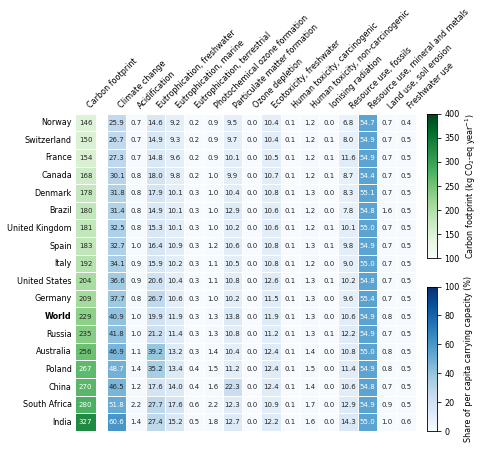

In [12]:
user = 'Medium technology user'
user_pb = CARRYING_CAPACITY_medium
fig_name = 'fig_2.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc_df, user_pb, fig_name)

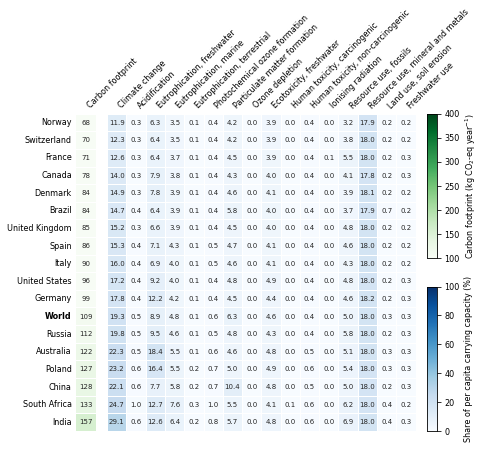

In [13]:
user = 'Low technology user'
user_pb = CARRYING_CAPACITY_low
fig_name = 'SI_Results_low_technology_user.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc_df, user_pb, fig_name)

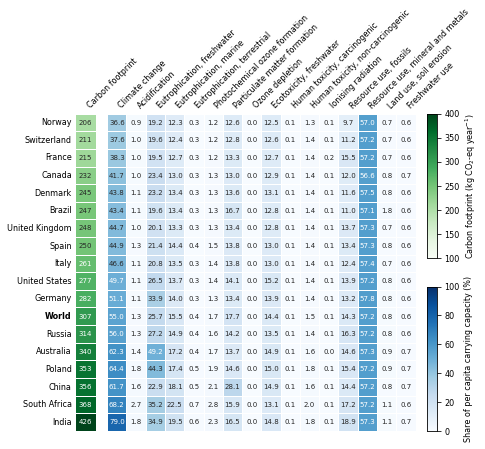

In [14]:
user = 'High technology user'
user_pb = CARRYING_CAPACITY_high
fig_name = 'SI_Results_high_technology_user.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc_df, user_pb, fig_name)

### Climate impacts under different carbon budgets

In [31]:
# Import carbon budgets for different targets and probabilities
CARBON_BUDGETS = pd.read_excel(Path(r"..\data\Sensitivity-Analysis-Carbon-Budgets.xlsx"), index_col=0)
CARBON_BUDGETS

,17%,33%,50%,67%,83%
Target,,,,,
1.5 °C,1126.268612,813.416220,625.704785,500.563828,375.422871
1.7 °C,1814.543875,1313.980048,1063.698134,875.986698,688.275263
2.0 °C,2878.242009,2127.396267,1689.402918,1439.121004,1126.268612


In [26]:
CARBON_BUDGETS_current = dict()
for target in CARBON_BUDGETS.index:
    CARBON_BUDGETS_current[target] = {}
    for prob in CARBON_BUDGETS.columns:
        CARBON_BUDGETS_current[target][prob] = {}
        for loc in LCIA_current['Medium technology user']:
            CARBON_BUDGETS_current[target][prob][loc] = LCIA_current['Medium technology user'][loc]['Climate change'] * 100 / CARBON_BUDGETS.loc[target, prob]

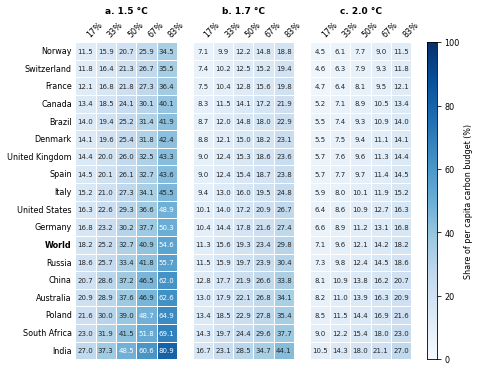

In [27]:
T_targets = list(CARBON_BUDGETS.index)

fig, axs = plt.subplot_mosaic([T_targets + ['cbar']],
                              figsize=(fig_length[2]*0.9, fig_height*0.6), 
                               gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})

axs[T_targets[0]].set_title('a. ' + T_targets[0], fontweight='bold', loc='center', fontsize=fontsize_title)
axs[T_targets[1]].set_title('b. ' + T_targets[1], fontweight='bold', loc='center', fontsize=fontsize_title)
axs[T_targets[2]].set_title('c. ' + T_targets[2], fontweight='bold', loc='center', fontsize=fontsize_title)

for tt in T_targets:
    data_to_plot = pd.DataFrame(CARBON_BUDGETS_current[tt]).sort_values('17%')
    sns.heatmap(ax=axs[tt], data=data_to_plot, cmap="Blues", vmin=0, vmax=100, 
                annot=True, fmt='.1f', annot_kws={"size": 7}, xticklabels=True, yticklabels=True, linewidths=0.8, linecolor='white', 
                cbar=True, cbar_ax=axs['cbar'])
    axs[tt].xaxis.tick_top()
    axs[tt].tick_params(axis='x', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[tt].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[tt].set_xticklabels(list(data_to_plot.columns), rotation = 45, ha="left", fontsize=fontsize_axs)

for tt in T_targets[1:]:
    axs[tt].set_yticklabels('')
for lab, annot in zip(axs[T_targets[0]].get_yticklabels(), axs[T_targets[0]].texts):
    text = lab.get_text()
    if text in ['Europe', 'World']:
        lab.set_weight('bold')
        
for spine in axs['cbar'].spines.values():
    spine.set(visible=True, lw=spineline_width, edgecolor="black")
axs['cbar'].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
axs['cbar'].set_ylabel('Share of per capita carbon budget (%)', fontsize=fontsize_label)

fig.subplots_adjust(wspace=0.2)
plt.savefig(Path(str(r"..\reports\submission") + '/SI_carbon_budget_sensitivity.jpg'), dpi=600, bbox_inches='tight')

## Uncertainty analysis - Monte Carlo simulation
Only for GLO location

In [21]:
GLO_user_ds = [ds for ds in bw.Database(DBS['Digital content']) if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]
GLO_user_ds

'digital content consumption, medium technology user' (year, GLO, None)

Impact values

In [55]:
iterations = 1000
methods_for_mc = {k:v for (k,v) in LCIA_METHODS.items() if k != 'Carbon footprint'}
MonteCarlo_results_GLO = multi_lcia_MonteCarlo(GLO_user_ds, iterations, methods_for_mc)

In [63]:
MonteCarlo_stats_GLO = pd.DataFrame(MonteCarlo_results_GLO).describe()
MonteCarlo_stats_GLO.loc['CV'] = MonteCarlo_stats_GLO.loc['std'] * 100 / MonteCarlo_stats_GLO.loc['mean']
MonteCarlo_stats_GLO.T.drop('count', axis=1)

,mean,std,min,25%,50%,75%,max,CV
Climate change,2.437470e+02,2.261993e+01,1.860682e+02,2.277398e+02,2.420690e+02,2.573148e+02,333.843113,9.280086
Acidification,1.690338e+00,1.617382e-01,1.283174e+00,1.572536e+00,1.680495e+00,1.786072e+00,2.293924,9.568398
"Eutrophication, freshwater",2.327124e-01,9.291904e-02,9.091923e-02,1.690651e-01,2.124511e-01,2.759755e-01,0.872439,39.928703
"Eutrophication, marine",4.378355e-01,4.324171e-02,3.394647e-01,4.045279e-01,4.338290e-01,4.652162e-01,0.670907,9.876244
"Eutrophication, terrestrial",3.242669e+00,3.505411e-01,2.478954e+00,3.004696e+00,3.212069e+00,3.452816e+00,4.755210,10.810266
Photochemical ozone formation,8.944549e-01,9.104980e-02,6.806799e-01,8.311978e-01,8.878608e-01,9.480427e-01,1.255824,10.179362
Particulate matter formation,1.574815e-05,9.007430e-06,7.053762e-06,1.075715e-05,1.330489e-05,1.757673e-05,0.000140,57.196759
Ozone depletion,2.038183e-05,5.399472e-06,1.013154e-05,1.677856e-05,1.942232e-05,2.284071e-05,0.000054,26.491599
"Ecotoxicity, freshwater",2.782832e+03,4.826274e+02,1.656881e+03,2.460657e+03,2.710453e+03,3.041056e+03,6061.694020,17.343033
"Human toxicity, carcinogenic",2.529512e-07,3.247112e-07,-9.631419e-07,5.997269e-08,2.364071e-07,4.356778e-07,0.000003,128.369072


Share of the personal carrying capacities

In [64]:
MonteCarlo_PB_GLO = dict()
for method in methods_for_mc:
    MonteCarlo_PB_GLO[method] = [i * 100 / carrying_capacity_per_capita['carrying_capacity_2020'].to_dict()[method] for i in MonteCarlo_results_GLO[method]]

In [65]:
MonteCarlo_stats_PB_GLO = pd.DataFrame(MonteCarlo_PB_GLO).describe()
MonteCarlo_stats_PB_GLO.loc['CV'] = MonteCarlo_stats_PB_GLO.loc['std'] * 100 / MonteCarlo_stats_PB_GLO.loc['mean']
MonteCarlo_stats_PB_GLO.loc['deterministic'] = CARRYING_CAPACITY_current['Medium technology user']['World']
MonteCarlo_stats_PB_GLO
MonteCarlo_stats_PB_GLO.T.drop('count', axis=1).round(2).astype(str) + '%'

,mean,std,min,25%,50%,75%,max,CV,deterministic
Climate change,48.69%,4.52%,37.17%,45.5%,48.36%,51.4%,66.69%,9.28%,40.92%
Acidification,1.32%,0.13%,1.0%,1.23%,1.31%,1.39%,1.79%,9.57%,1.04%
"Eutrophication, freshwater",31.22%,12.47%,12.2%,22.68%,28.5%,37.03%,117.06%,39.93%,19.9%
"Eutrophication, marine",14.65%,1.45%,11.36%,13.53%,14.51%,15.56%,22.44%,9.88%,11.89%
"Eutrophication, terrestrial",0.41%,0.04%,0.32%,0.38%,0.41%,0.44%,0.6%,10.81%,0.32%
Photochemical ozone formation,1.71%,0.17%,1.3%,1.59%,1.7%,1.82%,2.41%,10.18%,1.3%
Particulate matter formation,21.06%,12.05%,9.43%,14.39%,17.8%,23.51%,187.86%,57.2%,13.77%
Ozone depletion,0.04%,0.01%,0.02%,0.04%,0.04%,0.05%,0.12%,26.49%,0.03%
"Ecotoxicity, freshwater",16.73%,2.9%,9.96%,14.8%,16.3%,18.29%,36.45%,17.34%,11.93%
"Human toxicity, carcinogenic",0.18%,0.23%,-0.69%,0.04%,0.17%,0.31%,2.08%,128.37%,0.1%


## Contribution analysis by system component

In [15]:
locations_CA = ['NO', 'GLO', 'IN']

In [16]:
CA_system_medium_CH_GLO_IN = {}
for loc in locations_CA:
    activity = [ds for ds in bw.Database(DBS['Digital content']) if 'medium technology user' in ds['name'] and ds['location'] == loc][0]
    system_contributions = internet_system_contributions(activity, LCIA_METHODS, activity_amount=1)
    CA_system_medium_CH_GLO_IN[loc] = system_contributions

In [28]:
CA_system_absolute = pd.DataFrame(CA_system_medium_CH_GLO_IN['IN'])
CA_system_relative = (CA_system_absolute.T * 100 / CA_system_absolute.T.sum()).T
CA_system_relative

,End-user devices | operation,End-user devices | embodied,CPE | operation,CPE | embodied,Access network,Core network,Data centres | operation,Data centres | embodied
Carbon footprint,32.767368,22.699719,10.633815,0.153573,4.253526,12.072389,17.101765,0.317846
Climate change,33.892215,21.321340,10.998855,0.146411,4.399542,12.277356,16.662719,0.301563
Acidification,29.586494,30.190250,9.601543,0.289568,3.840617,10.797505,15.220967,0.473056
"Eutrophication, freshwater",27.827110,32.539024,9.030580,0.386019,3.612232,10.342549,15.693345,0.569141
"Eutrophication, marine",23.297786,36.469089,7.560703,0.165212,3.024281,8.373293,20.800982,0.308654
"Eutrophication, terrestrial",31.000248,28.858055,10.060341,0.232666,4.024136,10.939039,14.466551,0.418963
Photochemical ozone formation,30.235202,30.126749,9.812065,0.236101,3.924826,10.813756,14.383267,0.468035
Particulate matter formation,15.841290,45.285957,5.140887,0.312171,2.056355,8.412169,22.283878,0.667294
Ozone depletion,6.890687,64.191006,2.236197,0.378291,0.894479,5.651074,19.036516,0.721752
"Ecotoxicity, freshwater",9.511552,62.838896,3.086732,0.735606,1.234693,4.638183,16.883386,1.070953


In [18]:
#system_color = ['#762a83', '#9970ab', '#c2a5cf', '#e7d4e8', '#d9f0d3', '#a6dba0', '#5aae61', '#1b7837']
system_color = ['#b35806', '#e08214', '#fdb863', '#fee0b6', '#d8daeb', '#b2abd2', '#8073ac', '#542788']
system_color = ['navy', '#9970ab', '#c2a5cf', '#e7d4e8', '#d9f0d3', '#a6dba0', '#5aae61', '#1b7837']

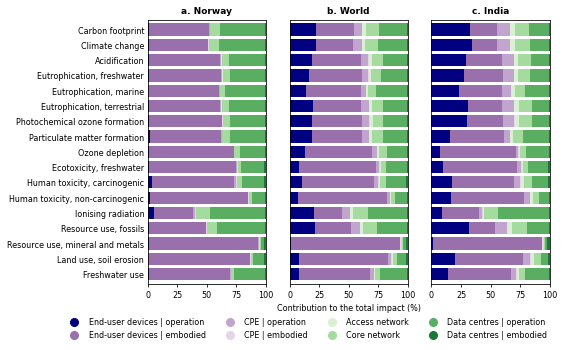

In [19]:
width=0.8

fig, axs = plt.subplots(1, 3, figsize=(fig_length[2], fig_height*0.5), sharey=True)

count_ax = 0
for loc in locations_CA:
    ds_plot = pd.DataFrame(CA_system_medium_CH_GLO_IN[loc])
    ds_plot = (ds_plot.T * 100 / ds_plot.T.sum()).T
    
    ds_plot.plot.barh(ax=axs[count_ax], stacked=True, width=width, fontsize=fontsize_axs, lw=spineline_width, color=system_color, legend=False, zorder=2)
    axs[count_ax].invert_yaxis()
    
    axs[count_ax].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[count_ax].tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
    
    axs[count_ax].set_xlim(0, 100)
    
    count_ax += 1

axs[1].set_xlabel('Contribution to the total impact (%)', fontsize=fontsize_label)

axs[0].set_title('a. Norway', fontweight='bold', loc='center', fontsize=fontsize_title)
axs[1].set_title('b. World', fontweight='bold', loc='center', fontsize=fontsize_title)
axs[2].set_title('c. India', fontweight='bold', loc='center', fontsize=fontsize_title)

patch_1 = Line2D([0], [0], color=system_color[0], label=INTERNET_COMPONENTS[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=system_color[1], label=INTERNET_COMPONENTS[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=system_color[2], label=INTERNET_COMPONENTS[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=system_color[3], label=INTERNET_COMPONENTS[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=system_color[4], label=INTERNET_COMPONENTS[4], ls='None', marker='o', ms=8)
patch_6 = Line2D([0], [0], color=system_color[5], label=INTERNET_COMPONENTS[5], ls='None', marker='o', ms=8)
patch_7 = Line2D([0], [0], color=system_color[6], label=INTERNET_COMPONENTS[6], ls='None', marker='o', ms=8)
patch_8 = Line2D([0], [0], color=system_color[7], label=INTERNET_COMPONENTS[7], ls='None', marker='o', ms=8)

axs[1].legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5, patch_6, patch_7, patch_8], 
              bbox_to_anchor=(2.24,-0.1), ncol=4, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports\submission") + '/fig_3.jpg'), dpi=600, bbox_inches='tight')

## Contribution analysis of embodied and operational impacts of end-user devices

Only for the GLO average user

In [22]:
user_devices_embodied_lcia = user_devices_embodied_impacts(GLO_user_ds, LCIA_METHODS, activity_amount=1)
user_devices_operational_lcia = user_devices_operational_impacts(GLO_user_ds, LCIA_METHODS, activity_amount=1)

In [23]:
user_devices_embodied_lcia_df = pd.DataFrame(user_devices_embodied_lcia)
user_devices_operational_lcia_df = pd.DataFrame(user_devices_operational_lcia)

In [24]:
user_devices_embodied_total_share = (user_devices_embodied_lcia_df.T * 100 / user_devices_embodied_lcia_df.T.sum()).T
user_devices_embodied_total_share

,Smartphone,Tablet,Laptop,Desktop computer,Television
Carbon footprint,14.684755,15.938573,20.978348,37.992854,10.405470
Climate change,14.492975,15.706093,20.987581,38.242493,10.570857
Acidification,10.821199,11.788920,19.295479,38.683409,19.410993
"Eutrophication, freshwater",10.117620,10.873174,21.414072,39.084005,18.511129
"Eutrophication, marine",8.681580,9.815791,16.529771,56.805243,8.167616
"Eutrophication, terrestrial",10.538248,11.522233,19.721586,43.308853,14.909080
Photochemical ozone formation,11.137123,11.832790,18.628028,40.027242,18.374816
Particulate matter formation,10.100420,11.146575,22.867092,38.337977,17.547936
Ozone depletion,23.114232,25.441983,16.616746,27.549294,7.277746
"Ecotoxicity, freshwater",6.237863,6.661858,20.607877,46.053259,20.439143


In [25]:
user_devices_operational_total_share = (user_devices_operational_lcia_df.T * 100 / user_devices_operational_lcia_df.T.sum()).T
user_devices_operational_total_share

,Smartphone,Tablet,Laptop,Desktop computer,Television
Carbon footprint,3.658307,2.873907,18.431338,66.248666,8.787783
Climate change,3.658307,2.873907,18.431338,66.248666,8.787783
Acidification,3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, freshwater",3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, marine",3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, terrestrial",3.658307,2.873907,18.431338,66.248666,8.787783
Photochemical ozone formation,3.658307,2.873907,18.431338,66.248666,8.787783
Particulate matter formation,3.658307,2.873907,18.431338,66.248666,8.787783
Ozone depletion,3.658307,2.873907,18.431338,66.248666,8.787783
"Ecotoxicity, freshwater",3.658307,2.873907,18.431338,66.248666,8.787783


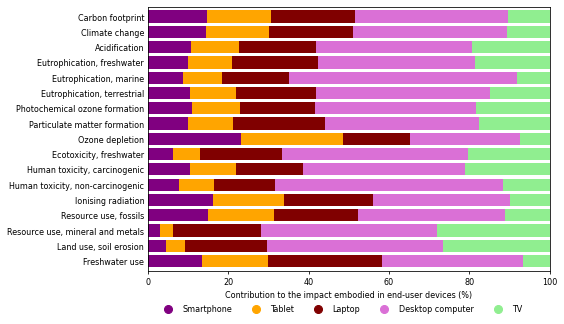

In [26]:
width=0.8
content_color = ['purple', 'orange', 'maroon', 'orchid', 'lightgreen']

fig, axs = plt.subplots(1, 1, figsize=(fig_length[2], fig_height*0.5))
    
user_devices_embodied_total_share.plot.barh(ax=axs, stacked=True, width=width, fontsize=fontsize_axs, color=content_color, legend=False, zorder=2)
axs.invert_yaxis()
    
axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
axs.tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
axs.set_xlim(0, 100)


axs.set_xlabel('Contribution to the impact embodied in end-user devices (%)', fontsize=fontsize_label)

patch_1 = Line2D([0], [0], color=content_color[0], label=END_USER_DEVICES[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=content_color[1], label=END_USER_DEVICES[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=content_color[2], label=END_USER_DEVICES[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=content_color[3], label=END_USER_DEVICES[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=content_color[4], label=END_USER_DEVICES[4], ls='None', marker='o', ms=8)

axs.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], 
              bbox_to_anchor=(0.95,-0.1), ncol=5, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports\submission") + '/SI_emboided_impacts_devices.jpg'), dpi=600, bbox_inches='tight')

## Contribution analysis by digital content

Only for the GLO user

In [29]:
CA_content_medium_GLO = digital_content_constributions(GLO_user_ds, LCIA_METHODS, DIGITAL_CONTENT, activity_amount=1)

In [30]:
CA_content_absolute = pd.DataFrame(CA_content_medium_GLO)
CA_content_relative = (CA_content_absolute.T * 100 / CA_content_absolute.T.sum()).T
CA_content_relative

,Web surfing,Social media,Video streaming,Music streaming,Video conferencing
Carbon footprint,14.902597,15.094173,47.342430,11.149760,11.511039
Climate change,14.797137,15.063834,47.564333,11.071217,11.503479
Acidification,14.824921,14.187618,48.100598,11.165036,11.721826
"Eutrophication, freshwater",14.875703,13.955135,48.321121,11.044556,11.803486
"Eutrophication, marine",14.796813,14.189216,46.284371,11.583542,13.146058
"Eutrophication, terrestrial",15.182337,14.359091,46.702054,11.515447,12.241071
Photochemical ozone formation,14.971371,14.268029,47.551456,11.349006,11.860138
Particulate matter formation,15.216210,14.107106,47.402718,11.274518,11.999449
Ozone depletion,17.838904,16.964610,41.678966,13.388961,10.128559
"Ecotoxicity, freshwater",15.321806,12.471179,47.448574,11.560420,13.198021


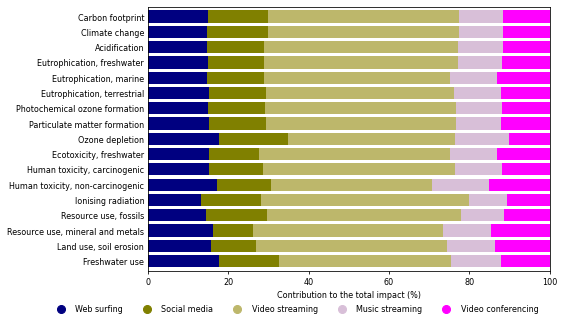

In [31]:
width=0.8
content_color = ['navy', 'olive', 'darkkhaki', 'thistle', 'fuchsia']

fig, axs = plt.subplots(1, 1, figsize=(fig_length[2], fig_height*0.5))
    
CA_content_relative.plot.barh(ax=axs, stacked=True, width=width, fontsize=fontsize_axs, color=content_color, legend=False, zorder=2)
axs.invert_yaxis()
    
axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
axs.tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
axs.set_xlim(0, 100)


axs.set_xlabel('Contribution to the total impact (%)', fontsize=fontsize_label)

patch_1 = Line2D([0], [0], color=content_color[0], label=DIGITAL_CONTENT[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=content_color[1], label=DIGITAL_CONTENT[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=content_color[2], label=DIGITAL_CONTENT[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=content_color[3], label=DIGITAL_CONTENT[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=content_color[4], label=DIGITAL_CONTENT[4], ls='None', marker='o', ms=8)

axs.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], 
               bbox_to_anchor=(0.99,-0.1), ncol=5, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports\submission") + '/SI_impacts_by_digital_content.jpg'), dpi=600, bbox_inches='tight')

# Prospective analysis

## Only background inventories prospective

In [32]:
LCIA_2030 = lcia_per_user_and_loc(USERS, {'GLO': 'World'}, DBS['Digital content 2030'], LCIA_METHODS)
LCIA_2040 = lcia_per_user_and_loc(USERS, {'GLO': 'World'}, DBS['Digital content 2040'], LCIA_METHODS)
LCIA_2050 = lcia_per_user_and_loc(USERS, {'GLO': 'World'}, DBS['Digital content 2050'], LCIA_METHODS)

In [33]:
CARRYING_CAPACITY_2030 = impacts_vs_carrying_capacity(USERS, {'GLO': 'World'}, LCIA_2030, carrying_capacity_per_capita['carrying_capacity_2030'])
CARRYING_CAPACITY_2040 = impacts_vs_carrying_capacity(USERS, {'GLO': 'World'}, LCIA_2040, carrying_capacity_per_capita['carrying_capacity_2040'])
CARRYING_CAPACITY_2050 = impacts_vs_carrying_capacity(USERS, {'GLO': 'World'}, LCIA_2050, carrying_capacity_per_capita['carrying_capacity_2050'])

In [34]:
LCIA_METHODS_PROSPECTIVE = {impact: LCIA_METHODS[impact] for impact in ['Carbon footprint',
                                                                        'Eutrophication, freshwater',
                                                                        'Eutrophication, marine',
                                                                        'Particulate matter formation',
                                                                        'Ecotoxicity, freshwater',
                                                                        'Resource use, mineral and metals']}

In [35]:
CA_system_medium_prospective = {}

for db in [DBS['Digital content 2030'], DBS['Digital content 2040'], DBS['Digital content 2050']]:
    CA_system_medium_prospective[db] = {}
    activity = [ds for ds in bw.Database(db) if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]
    CA_system_medium_prospective[db] = internet_system_contributions(activity, LCIA_METHODS_PROSPECTIVE, activity_amount=1)

In [36]:
CA_system_medium_timeserie = {}
for impact in LCIA_METHODS_PROSPECTIVE:
    CA_system_medium_timeserie[impact] = {}
    for system in INTERNET_COMPONENTS:
        CA_system_medium_timeserie[impact][system] = {}
        CA_system_medium_timeserie[impact][system]['Current'] = CA_system_medium_CH_GLO_IN['GLO'][system][impact]
        CA_system_medium_timeserie[impact][system]['2030'] = CA_system_medium_prospective[DBS['Digital content 2030']][system][impact]
        CA_system_medium_timeserie[impact][system]['2040'] = CA_system_medium_prospective[DBS['Digital content 2040']][system][impact]
        CA_system_medium_timeserie[impact][system]['2050'] = CA_system_medium_prospective[DBS['Digital content 2050']][system][impact]

In [37]:
CA_system_medium_PB_timeserie = {}
for impact in LCIA_METHODS_PROSPECTIVE:

    if impact == 'Carbon footprint':
        impact_cc = 'Climate change'
    else:
        impact_cc = impact
    
    CA_system_medium_PB_timeserie[impact] = {}
    CA_system_medium_PB_timeserie[impact]['Current'] = CARRYING_CAPACITY_current['Medium technology user']['World'][impact_cc]
    CA_system_medium_PB_timeserie[impact]['2030'] = CARRYING_CAPACITY_2030['Medium technology user']['World'][impact_cc]
    CA_system_medium_PB_timeserie[impact]['2040'] = CARRYING_CAPACITY_2040['Medium technology user']['World'][impact_cc]
    CA_system_medium_PB_timeserie[impact]['2050'] = CARRYING_CAPACITY_2050['Medium technology user']['World'][impact_cc]

In [41]:
CA_system_medium_timeserie['Eutrophication, marine']

{'End-user devices | operation': {'Current': 0.04846885736509268,
  '2030': 0.013372930892444035,
  '2040': 0.010501847696227343,
  '2050': 0.010027818553581648},
 'End-user devices | embodied': {'Current': 0.16528690379807093,
  '2030': 0.12563299153980018,
  '2040': 0.12262199299795584,
  '2050': 0.12204546562905506},
 'CPE | operation': {'Current': 0.015729333066279907,
  '2030': 0.004339844087826351,
  '2040': 0.003408107168300451,
  '2050': 0.0032542730844549485},
 'CPE | embodied': {'Current': 0.0007487808263817544,
  '2030': 0.000458001511840624,
  '2040': 0.00043704742923950834,
  '2050': 0.0004340860039288784},
 'Access network': {'Current': 0.0062917330021717245,
  '2030': 0.0017359375732333311,
  '2040': 0.0013632428187119099,
  '2050': 0.001301709187367783},
 'Core network': {'Current': 0.023088808309786338,
  '2030': 0.006325458522989806,
  '2040': 0.005121142646138572,
  '2050': 0.005028057335195705},
 'Data centres | operation': {'Current': 0.09427517977800984,
  '2030':

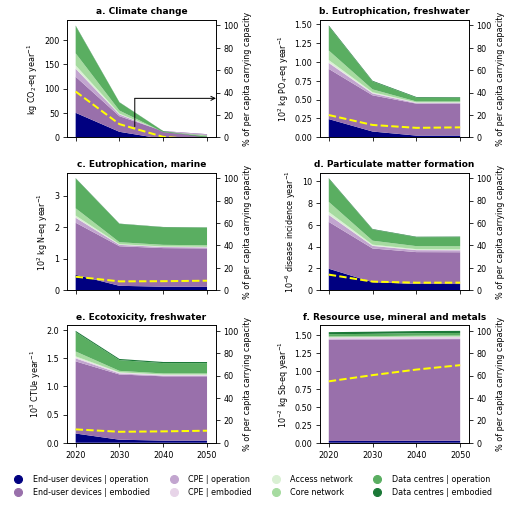

In [43]:
prospective_categories = list(LCIA_METHODS_PROSPECTIVE.keys())
categories_titles = ['a. Climate change',
                     'b. Eutrophication, freshwater',
                     'c. Eutrophication, marine',
                     'd. Particulate matter formation',
                     'e. Ecotoxicity, freshwater',
                     'f. Resource use, mineral and metals']
categories_units = ['kg CO$_2$-eq year$^{-1}$',
                    '10$^{2}$ kg PO$_4$-eq year$^{-1}$',
                    '10$^{2}$ kg N-eq year$^{-1}$',
                    '10$^{-6}$ disease incidence year$^{-1}$',
                    '10$^{3}$ CTUe year$^{-1}$',
                    '10$^{-2}$ kg Sb-eq year$^{-1}$',]
multiply_values = [1,
                   10,
                   10,
                   1e6, 
                   1e-3,
                   1e2]

fig, axs = plt.subplots(3, 2, figsize=(fig_length[2], fig_height*0.8), sharex=True)

counter=0
for row in range(3):
    for col in range(2):
        axs[row,col].set_title(categories_titles[counter], fontweight='bold', loc='center', fontsize=fontsize_title)
        axs[row,col].set_ylabel(categories_units[counter], fontsize=fontsize_label) 
        
        data_to_plot = [list(CA_system_medium_timeserie[prospective_categories[counter]][i].values()) for i in CA_system_medium_timeserie[prospective_categories[counter]]]
        data_to_plot = [[j*multiply_values[counter] for j in i] for i in data_to_plot]
        
        axs[row,col].stackplot([2020, 2030, 2040, 2050], data_to_plot, labels=INTERNET_COMPONENTS, colors=system_color, zorder=3)
        axs[row,col].set_ylim(ymin=0)

        axs1 = axs[row,col].twinx()
        axs1.plot([2020, 2030, 2040, 2050], list(CA_system_medium_PB_timeserie[prospective_categories[counter]].values()),
                  color='yellow', lw=2, ls='--')
        axs1.set_ylim(0,105)
        axs1.tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
        axs1.set_ylabel('% of per capita carrying capacity', fontsize=fontsize_label) 

        axs[row,col].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
        axs[row,col].tick_params(axis='x', which='major', direction='out', length=4, labelsize=fontsize_axs)
        axs[row,col].yaxis.offsetText.set_fontsize(fontsize_axs)
        axs[row,col].set_xticks([2020, 2030, 2040, 2050], )
        axs[row,col].set_xlim(2018,2052)
    #    axs[row,col].grid(ls='--', lw=0.5, zorder=0)

        counter += 1 

axs[0,0].annotate(text='', xy=(2033,80), xytext=(2052.5,80), arrowprops=dict(arrowstyle='<-'))
axs[0,0].annotate(text='', xy=(2033.5,18), xytext=(2033.5,83), arrowprops=dict(arrowstyle='-'))

# LEGEND
patch_1 = Line2D([0], [0], color=system_color[0], label=INTERNET_COMPONENTS[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=system_color[1], label=INTERNET_COMPONENTS[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=system_color[2], label=INTERNET_COMPONENTS[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=system_color[3], label=INTERNET_COMPONENTS[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=system_color[4], label=INTERNET_COMPONENTS[4], ls='None', marker='o', ms=8)
patch_6 = Line2D([0], [0], color=system_color[5], label=INTERNET_COMPONENTS[5], ls='None', marker='o', ms=8)
patch_7 = Line2D([0], [0], color=system_color[6], label=INTERNET_COMPONENTS[6], ls='None', marker='o', ms=8)
patch_8 = Line2D([0], [0], color=system_color[7], label=INTERNET_COMPONENTS[7], ls='None', marker='o', ms=8)

axs[2,1].legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5, patch_6, patch_7, patch_8], 
                bbox_to_anchor=(1.2,-0.21), ncol=4, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

#line = Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Share of per capita carrying capacity')
#axs[1,0].legend(handles=[line], bbox_to_anchor=(2,-0.44), frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

fig.subplots_adjust(wspace=0.7, hspace=0.3)
plt.savefig(Path(str(r"..\reports\submission") + '/fig_4.jpg'), dpi=600, bbox_inches='tight')

In [44]:
impacts_2020_vs_2050 = pd.concat([pd.DataFrame(LCIA_current['Medium technology user'])[['World']], pd.DataFrame(LCIA_2050['Medium technology user'])], axis=1)
impacts_2020_vs_2050.columns = ['Current', 'P_2050']
impacts_2020_vs_2050['Diff'] = (impacts_2020_vs_2050.P_2050 - impacts_2020_vs_2050.Current) / impacts_2020_vs_2050.Current * 100
impacts_2020_vs_2050

,Current,P_2050,Diff
Carbon footprint,2.294244e+02,-7.421089e-01,-100.323466
Climate change,2.048390e+02,-1.202878e+01,-105.872311
Acidification,1.333010e+00,4.555044e-01,-65.828886
"Eutrophication, freshwater",1.483092e-01,5.300253e-02,-64.262133
"Eutrophication, marine",3.552885e-01,1.989480e-01,-44.003828
"Eutrophication, terrestrial",2.498261e+00,1.080604e+00,-56.745762
Photochemical ozone formation,6.798044e-01,3.077926e-01,-54.723356
Particulate matter formation,1.029470e-05,4.915309e-06,-52.254001
Ozone depletion,1.302457e-05,1.220900e-05,-6.261817
"Ecotoxicity, freshwater",1.983217e+03,1.430715e+03,-27.858864


In [45]:
pd.DataFrame(CARRYING_CAPACITY_2050['Medium technology user']['World'], index=['value']).T

,value
Climate change,-2.403047
Acidification,0.443435
"Eutrophication, freshwater",8.881540
"Eutrophication, marine",8.312297
"Eutrophication, terrestrial",0.171610
Photochemical ozone formation,0.736823
Particulate matter formation,6.574225
Ozone depletion,0.033015
"Ecotoxicity, freshwater",10.744503
"Human toxicity, carcinogenic",0.080462


## Background + foreground inventories prospective with presamples

In [46]:
sensitivity_analysis_data = Path(r"..\data\Sensitivity-Analysis-LCI-for-Presamples.xlsx")

In [47]:
def read_presamples_scenario_data(scenario_file, Ecoinvent_db, Other_db):
    """
    This function reads the scenario data from an excel file and prepares it into a dataframe for being used with Presamples.
    Secondly, it adds the bw codes for the involved activities.
    The dictionary map_bw_keys provides these codes, it needs to be generated beforehand with the involved databases.    
    """

    # Create mapping of BW codes for involved databases
    map_bw_keys = dict()
    for db in [Ecoinvent_db, Other_db]:
        db_obj = bw.Database(db)
        for ds in db_obj:
            map_bw_keys[(ds['reference product'], ds['name'], ds['location'])] = ds.key
    
    scenariodata_df = pd.read_excel(scenario_file) # Import data
    scenariodata_df = scenariodata_df.dropna(how="all") # Delete empty rows
    
    scenario_label = list(scenariodata_df.columns)[9:] # Get label of scenarios
    
    # add the bw code to your scenario DF (input = process, output = to_process)
    scenariodata_df["input"] = [map_bw_keys[(row["from_reference_product"], row["from_process"], row["from_location"])] 
                                for index, row in scenariodata_df.iterrows()]
    scenariodata_df["output"] = [map_bw_keys[(row["to_reference product"], row["to_process"], row["to_location"])] 
                                 for index, row in scenariodata_df.iterrows()]

    return scenario_label, scenariodata_df

In [48]:
def make_pspackage(scenariodata_df, scenario_label, matrixlabel, ps_packagename):
    """
    This function prepares a Presamples package out of the scenario data if.
    """
        
    # select needed data
    samples = scenariodata_df[scenario_label].values
    indices = [(row['input'], row['output'], row['from_type']) for i, row in scenariodata_df.iterrows()] 

    # Generate PS data in PSpackage
    data = [(samples, indices, matrixlabel)]
    
    ps_id, ps_filepath = ps.create_presamples_package(matrix_data=data, name=ps_packagename, seed="sequential") 
    
    print("\n ps_id, filepath:", ps_id, ps_filepath)
    
    return samples, indices, ps_filepath

In [49]:
# Read the excel file to get the scenario data
scenario_label, scenariodata_df = read_presamples_scenario_data(sensitivity_analysis_data, DBS['Ecoinvent 2050'], DBS['Digital content 2050'])
scenariodata_df.head()

,to_reference product,to_process,to_location,to_database,from_reference_product,from_process,from_location,from_type,from_database,default,energy_efficiency,energy_efficiency_25%_lifetime,energy_efficiency_50%_lifetime,energy_efficiency_100%_lifetime,input,output
0,"costumer premise equipment, internet access","costumer premise equipment, internet access",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",GLO,technosphere,ecoinvent,0.007000,0.003818,0.003818,0.003818,0.003818,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
1,"access network, internet access","access network, internet access",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",GLO,technosphere,ecoinvent,0.002800,0.001527,0.001527,0.001527,0.001527,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
2,"core network, internet access, access network ...","core network, internet access, access network ...",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",GLO,technosphere,ecoinvent,0.008858,0.004832,0.004832,0.004832,0.004832,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
3,"core network, internet access, data centers node","core network, internet access, data centers node",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",RNA,technosphere,ecoinvent,0.003440,0.001876,0.001876,0.001876,0.001876,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
4,"core network, internet access, data centers node","core network, internet access, data centers node",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",RAS,technosphere,ecoinvent,0.003031,0.001653,0.001653,0.001653,0.001653,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."


In [50]:
# Create PS package with indices + samples matrix
samples_v1, indices_v1, ps_filepath_v1 =  make_pspackage(scenariodata_df, scenario_label, "technosphere", "ps_v1")


 ps_id, filepath: f1d1e669419742c78088671bd6177d58 C:\Users\iistrate\AppData\Local\pylca\Brightway3\iri.5753d2a2da40d04ad7f3cc7a024b6e90\presamples\f1d1e669419742c78088671bd6177d58


In [51]:
activity_for_ps = [ds for ds in bw.Database(DBS['Digital content 2050']) if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]
activity_for_ps_lca = bw.LCA({activity_for_ps:1}, presamples=[ps_filepath_v1])

sensitivity_analysis_lcia = dict()
for impact in LCIA_METHODS:
    sensitivity_analysis_lcia[impact] = {}

scenario_lcia = dict()
for i in range(len(scenario_label)): # Scenarios
    if i == 0: # Don't update the first time around, since indexer already at 0th column
        activity_for_ps_lca.lci() # Builds matrices
        multi_lcia_results = dict()
        for impact in LCIA_METHODS:
            activity_for_ps_lca.switch_method(LCIA_METHODS[impact])
            activity_for_ps_lca.lcia()
            multi_lcia_results[impact] = activity_for_ps_lca.score
    else:
        activity_for_ps_lca.presamples.update_matrices() # Move to next column and update matrices
        activity_for_ps_lca.redo_lci()
        multi_lcia_results = dict()
        for impact in LCIA_METHODS:
            activity_for_ps_lca.switch_method(LCIA_METHODS[impact])
            activity_for_ps_lca.lcia()
            multi_lcia_results[impact] = activity_for_ps_lca.score
                
    scenario_lcia[scenario_label[i]] = multi_lcia_results

    for impact in LCIA_METHODS:
        sensitivity_analysis_lcia[impact][scenario_label[i]] = scenario_lcia[scenario_label[i]][impact]

In [52]:
sensitivity_analysis_lcia_df = pd.DataFrame(sensitivity_analysis_lcia).T
sensitivity_analysis_lcia_df

,default,energy_efficiency,energy_efficiency_25%_lifetime,energy_efficiency_50%_lifetime,energy_efficiency_100%_lifetime
Carbon footprint,-7.229038e-01,7.057033e+00,4.446652e+00,2.712418e+00,5.446251e-01
Climate change,-1.201495e+01,-1.729359e+00,-3.085357e+00,-3.982950e+00,-5.104943e+00
Acidification,4.557201e-01,3.866304e-01,3.237054e-01,2.822946e-01,2.305312e-01
"Eutrophication, freshwater",5.304073e-02,4.945062e-02,4.063110e-02,3.478113e-02,2.746867e-02
"Eutrophication, marine",1.989869e-01,1.830656e-01,1.584590e-01,1.420081e-01,1.214445e-01
"Eutrophication, terrestrial",1.081055e+00,8.716538e-01,7.427320e-01,6.569493e-01,5.497208e-01
Photochemical ozone formation,3.079283e-01,2.479854e-01,2.104373e-01,1.854790e-01,1.542811e-01
Particulate matter formation,4.918011e-06,4.032702e-06,3.433120e-06,3.034370e-06,2.535932e-06
Ozone depletion,1.221275e-05,9.719075e-06,8.256545e-06,7.280013e-06,6.059348e-06
"Ecotoxicity, freshwater",1.431591e+03,1.369442e+03,1.134407e+03,9.778663e+02,7.821901e+02


In [53]:
sensitivity_analysis_lcia_carrying_capacity = sensitivity_analysis_lcia_df.iloc[1:].divide(carrying_capacity_per_capita['carrying_capacity_2050'], axis=0).multiply(100)
sensitivity_analysis_lcia_carrying_capacity

,default,energy_efficiency,energy_efficiency_25%_lifetime,energy_efficiency_50%_lifetime,energy_efficiency_100%_lifetime
Climate change,-2.400283,-0.345482,-0.616376,-0.795693,-1.019839
Acidification,0.443645,0.376386,0.315128,0.274815,0.224423
"Eutrophication, freshwater",8.887942,8.286352,6.808482,5.828212,4.602876
"Eutrophication, marine",8.313922,7.648711,6.620618,5.933278,5.074104
"Eutrophication, terrestrial",0.171682,0.138427,0.117953,0.104330,0.087301
Photochemical ozone formation,0.737148,0.593651,0.503765,0.444017,0.369333
Particulate matter formation,6.577840,5.393739,4.591798,4.058469,3.391809
Ozone depletion,0.033025,0.026282,0.022327,0.019686,0.016386
"Ecotoxicity, freshwater",10.751078,10.284349,8.519267,7.343662,5.874156
"Human toxicity, carcinogenic",0.080504,0.070787,0.059287,0.051721,0.042265


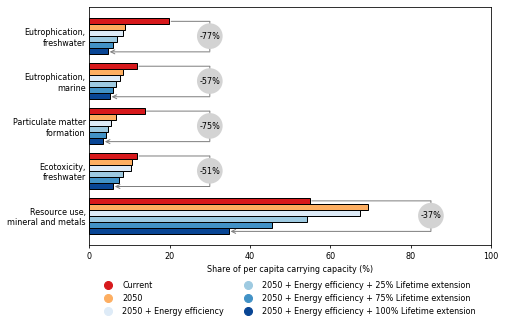

In [54]:
width=0.8

fig, axs = plt.subplots(1, 1, figsize=(fig_length[2], fig_height*0.45))

sensitivity_color = ['#d7191c', '#fdae61', '#deebf7', '#9ecae1', '#4292c6', '#084594']
df_to_plot = sensitivity_analysis_lcia_carrying_capacity.loc[['Eutrophication, freshwater',
                                                              'Eutrophication, marine',  
                                                              'Particulate matter formation',  
                                                              'Ecotoxicity, freshwater',
                                                              'Resource use, mineral and metals'
                                                            ]].T

df_to_plot = pd.concat([pd.DataFrame(CARRYING_CAPACITY_medium.loc[['Eutrophication, freshwater',
                                                                   'Eutrophication, marine',  
                                                                   'Particulate matter formation',  
                                                                   'Ecotoxicity, freshwater',
                                                                   'Resource use, mineral and metals',
                                                                   ]]['World']).T, df_to_plot])
df_to_plot.T.plot.barh(ax=axs, fontsize=fontsize_axs, color=sensitivity_color, width=width, edgecolor='black', legend=False, zorder=2)

axs.invert_yaxis()
axs.set_xlim(0, 100)

axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
axs.tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)

#axs.grid(ls='--', lw=0.5, zorder=0)
axs.set_xlabel('Share of per capita carrying capacity (%)', fontsize=fontsize_label)

labels = [item.get_text() for item in axs.get_yticklabels()]
labels[0] = 'Eutrophication,\nfreshwater'
labels[1] = 'Eutrophication,\nmarine'
labels[2] = 'Particulate matter\nformation'
labels[3] = 'Ecotoxicity,\nfreshwater'
labels[4] = 'Resource use,\nmineral and metals'
axs.set_yticklabels(labels)

percentage_reduction = (df_to_plot.loc['energy_efficiency_100%_lifetime'] - df_to_plot.loc['World']) * 100 / df_to_plot.loc['World']
count_ax_pos = 0
move_pos = 0

for cat in ['Eutrophication, freshwater', 'Eutrophication, marine', 'Particulate matter formation', 'Ecotoxicity, freshwater', 'Resource use, mineral and metals']:
    if cat in ['Eutrophication, freshwater', 'Eutrophication, marine', 'Particulate matter formation', 'Ecotoxicity, freshwater']:
        text_pos = 30
    else:
        text_pos = 85

    axs.annotate(text='', xy=(df_to_plot.loc['World'][cat], -0.33+move_pos), xytext=(text_pos+0.5,-0.33+move_pos), arrowprops=dict(arrowstyle='-', color='grey'))
    axs.annotate(text='', xy=(df_to_plot.loc['energy_efficiency_100%_lifetime'][cat], 0.35+move_pos), xytext=(text_pos+0.5,0.35+move_pos), arrowprops=dict(arrowstyle='->', color='grey'))
    axs.annotate(text='', xy=(text_pos, -0.37+move_pos), xytext=(text_pos,0.38+move_pos), arrowprops=dict(arrowstyle='-', color='grey'), va='center')

    axs.text(text_pos, count_ax_pos, str(round(percentage_reduction[cat])) + '%', ha="center", va="center", rotation=0, size=fontsize_axs, bbox=dict(boxstyle="circle,pad=0.3", fc="lightgrey", ec="None", lw=2))
    move_pos += 1
    count_ax_pos += 1 

# LEGEND
patch_0 = Line2D([0], [0], color=sensitivity_color[0], label='Current', ls='None', marker='o', ms=8)
patch_1 = Line2D([0], [0], color=sensitivity_color[1], label='2050', ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=sensitivity_color[2], label='2050 + Energy efficiency', ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=sensitivity_color[3], label='2050 + Energy efficiency + 25% Lifetime extension', ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=sensitivity_color[4], label='2050 + Energy efficiency + 75% Lifetime extension', ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=sensitivity_color[5], label='2050 + Energy efficiency + 100% Lifetime extension', ls='None', marker='o', ms=8)

axs.legend(handles=[patch_0, patch_1, patch_2, patch_3, patch_4, patch_5], 
                bbox_to_anchor=(0.98,-0.12), ncol=2, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports\submission") + '/fig_5.jpg'), dpi=600, bbox_inches='tight')